In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

In [2]:
df = pd.read_csv('hotaling_cocktails - Cocktails.csv')

In [ ]:
'''
Context

I'm a fan of cocktails, and thought it would be interesting to share a list of some cocktails created by professional
bartenders!

Content

This dataset contains cocktails collected by alcohol importer and distiller Hotaling & Co.
Original data at: http://www.hotalingandco.com/cocktails/. Provided information in natural text:

Drink provenance (if known/applicable)
Ingredients
Garnishes
Instructions
Inspiration

There are some interesting NLP tasks that can be done with this data, including but not limited to:

NLG to create cocktails 
Alcohol and mixer complementarity


Cocktail Name Cocktail name
Bartender Bartender who created this cocktail (Optional)
Bar/Company Bar or company the bartender is associated with (Optional)
Location Location of the company (Optional)
Ingredients Ingredients and quantities, comma-separated
Garnish Garnishes, comma-separated
Glassware Type of serving glass (Optional)
Preparation Instructions for preparing cocktail, period-separated
Notes Free text notes

'''

In [118]:
df.head()

,Cocktail Name,Bartender,Bar/Company,Location,Ingredients,Garnish,Glassware,Preparation,Notes
0,Flor de Amaras,Kelly McCarthy,NaN,Boston,"1.5 oz Mezcal, 1 oz Hibiscus Simple Syrup*, .5...",Marigold Petals,NaN,*Hibiscus Simple Syrup:\n1:1 w/ a cup of dried...,NaN
1,The Happy Place,Elizabeth Montana,Forgery & Verso,San Francisco,"2 oz Junipero Gin, .75 oz House-made Cranberry...","Dehydrated Lemon Wheel, Sprig of Rosemary",NaN,*House-made Cranberry syrup: \n-- 2 cups Fresh...,Junipero Gin 20th Anniversary Signature Cocktail
2,Bon Voyage Pisco Punch,Jon Morales,NaN,San Francisco,"1500 ml BarSol Selecto Italia Pisco, 750 ml Le...",NaN,punch bowl,*Pineapple Gomme: \nMix equal parts (1.5 cups)...,NaN
3,Still Life of a Pineapple,Daniel Braganca,Backbar,Somerville,"1.5 oz BarSol Primero Quebranta Pisco, .75 oz ...",NaN,NaN,*Pineapple Syrup:\n<em>Equal parts pineapple b...,NaN
4,The Bittered Valley,Nik Virrey,NaN,Seattle,"1.25 oz Luxardo Maraschino Liqueur, 4 drops Ac...",NaN,NaN,"1st glass ingredients:\nLuxardo Maraschino, Ac...",NaN


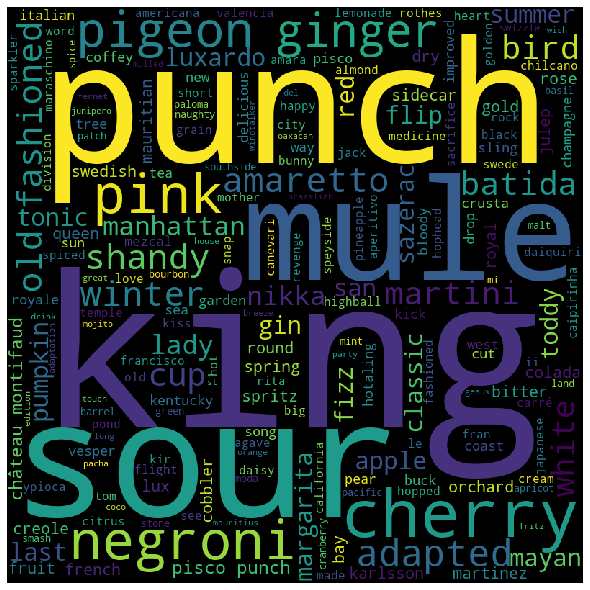

In [119]:
df['Cocktail Name Prep'] = df['Cocktail Name'].apply(lambda x: x.lower())
text = " ".join(name for name in df['Cocktail Name Prep'])

stopwords = set(STOPWORDS) 
stopwords.update(["cocktail", 'la', 'de'])

wordcloud = WordCloud(width=800, height=800, 
               background_color ='black', 
               stopwords=stopwords, 
               min_font_size=10,
               random_state=0
                     ).generate(text) 

plt.figure(figsize = (8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

wordcloud.to_file("cocktail name.png")

In [123]:
def plot_hist(data, f, title, min_val=1):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    tmp = data.groupby(f).filter(lambda x: len(x) >= min_val)
    
    plot = sns.countplot(
        data=tmp,
        y=f,
        order=tmp[f].value_counts().index,
        palette=sns.color_palette(n_colors=tmp[f].nunique())
    )
    plot.set_title(title, fontsize=20)
    plot.set_xlabel('Count', fontsize=15)
    plot.set_ylabel(f, fontsize=15)
    plt.tight_layout()
    plt.savefig('{}.png'.format(title.replace('/', '-')))
    plt.show()

In [54]:
# Which locations are popular?

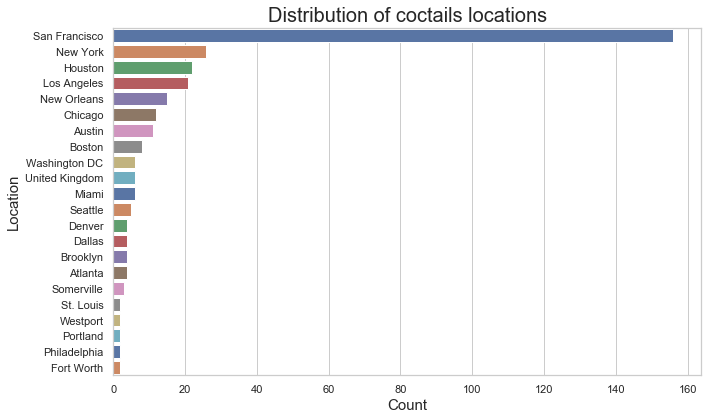

In [121]:
plot_hist(df, f='Location', title='Distribution of coctails locations', min_val=2)

In [ ]:
# What are most popular bars/companies?

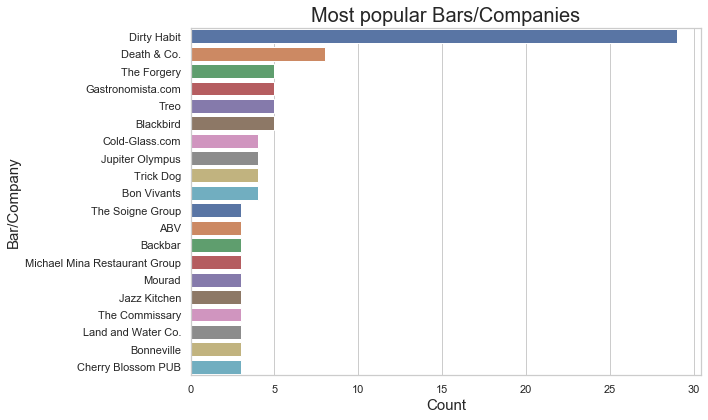

In [125]:
plot_hist(df, 'Bar/Company', 'Most popular Bars/Companies', min_val=3)

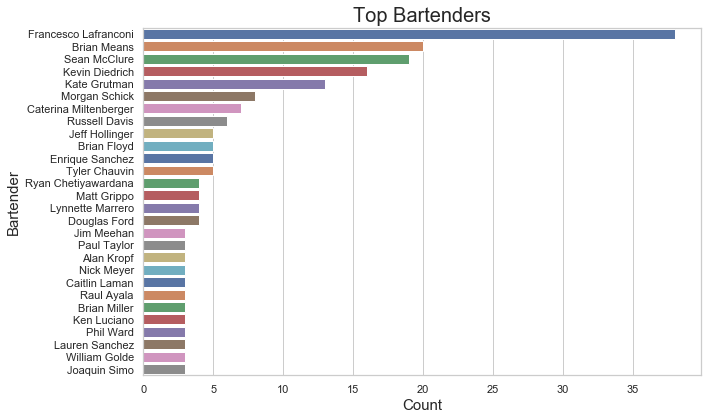

In [126]:
plot_hist(df, 'Bartender', 'Top Bartenders', min_val=3)

<Figure size 720x432 with 0 Axes>

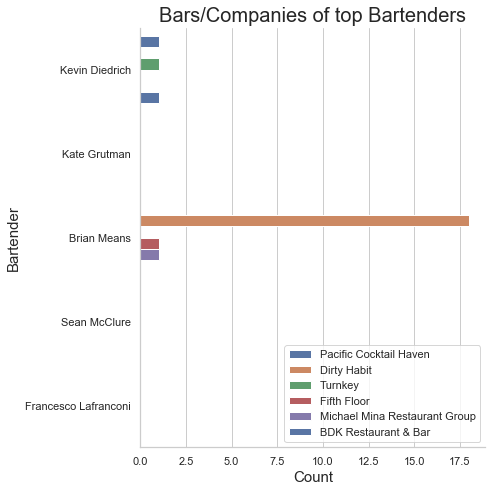

In [127]:
plt.figure(figsize=(10,6))
top_5 = df.Bartender.value_counts().index[:5]

catplot = sns.catplot(y="Bartender", hue="Bar/Company", kind="count", height=7,
            palette=sns.color_palette(n_colors=5), 
            data=df[df['Bartender'].isin(top_5)][['Bartender', 'Bar/Company']],
            legend_out=False)

plt.legend(loc='lower right')
title = 'Bars/Companies of top Bartenders'
plt.title(title, fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Bartender', fontsize=15)
plt.tight_layout()
plt.savefig('{}.png'.format(title.replace('/', '-')))
plt.show()

In [ ]:
# Predict Bartender by the ingredients

In [3]:
i = df.set_index('Bartender').Ingredients.str.split(',', expand=True).stack().reset_index('Bartender').reset_index(drop=True)
i.columns = ['Bartender', 'Ingredients']
i['Ingredients'] = i['Ingredients'].str.replace('.?[0-9]\.?[0-9]?( oz )?', '')
i['Ingredients'] = i['Ingredients'].str.replace('dash|ml|tsp', '')
i['Ingredients'] = i['Ingredients'].map(str.strip)
i['Ingredients'] = i['Ingredients'].str.lower()

In [4]:
tmp = i.Ingredients.value_counts().to_frame()
i = i.set_index('Ingredients')
i['global_count'] = tmp['Ingredients']

i = i.reset_index()
tmp = i.groupby('Bartender').Ingredients.value_counts().to_frame()

i = i.set_index(['Bartender', 'Ingredients'])
i['local_count'] = tmp['Ingredients']
i = i.reset_index()

i = i.drop_duplicates()

i['ingredients_by_bartender'] = i.local_count / i.global_count

In [5]:
def f(x):
    return x.sort_values('ingredients_by_bartender', ascending=False)['Ingredients'][:3]

tmp = i.groupby('Bartender').apply(lambda x: f(x)).to_frame().reset_index()
tmp.drop('level_1', axis=1, inplace=True)

In [6]:
top_10_bartenders = list(df.Bartender.value_counts()[:10].to_frame().index)
tmp = tmp[tmp.Bartender.isin(top_10_bartenders)]
tmp = tmp.groupby('Bartender').Ingredients.apply(lambda x: x.tolist()).to_frame().reset_index()

Brian Floyd


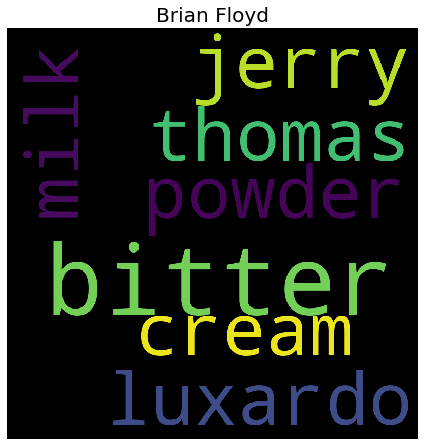

Brian Means


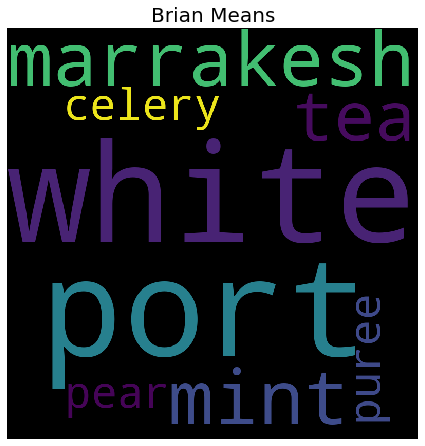

Caterina Miltenberger


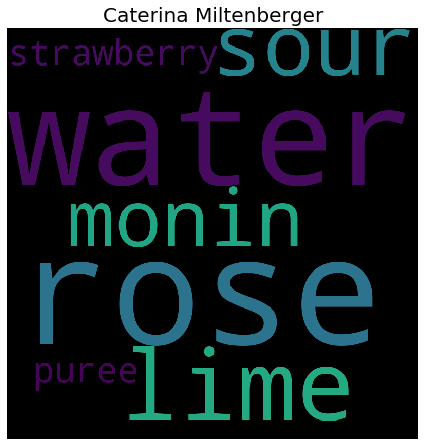

Enrique Sanchez


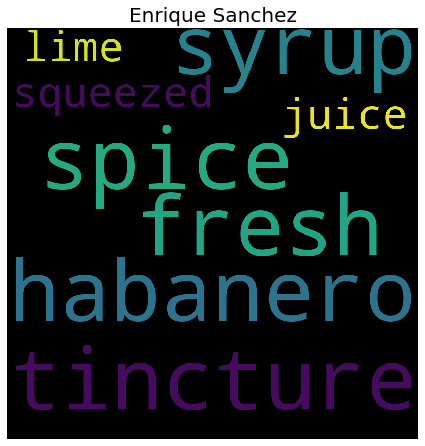

Francesco Lafranconi


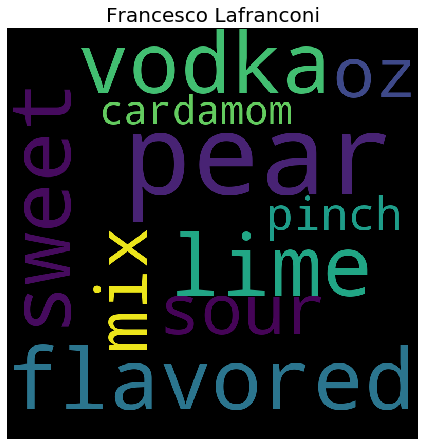

Kate Grutman


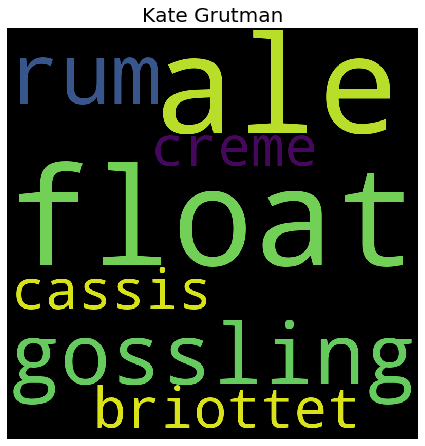

Kevin Diedrich


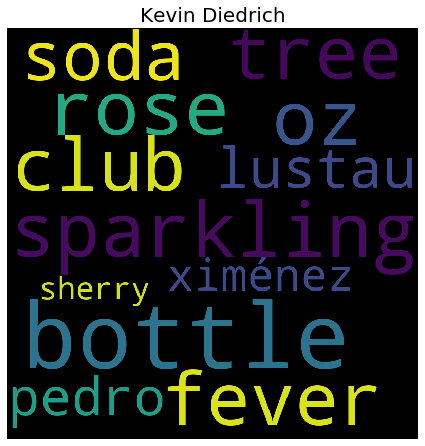

Morgan Schick


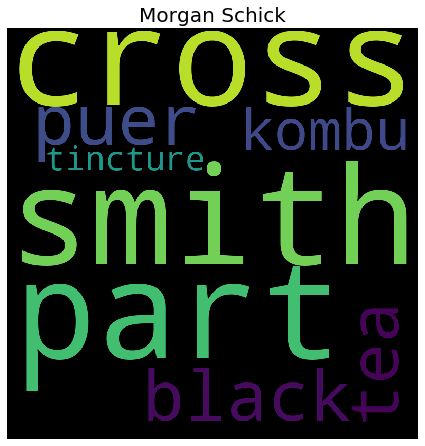

Russell Davis
tomato juice by hine (brown butter-infused) honey jalapeño syrup


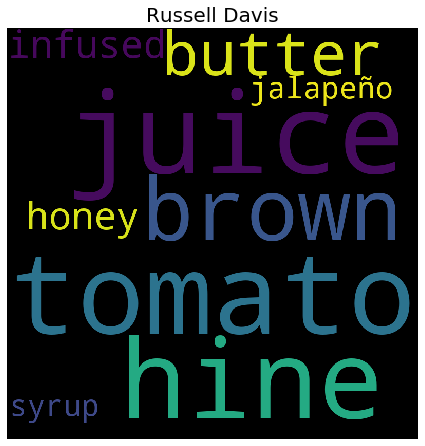

Sean McClure


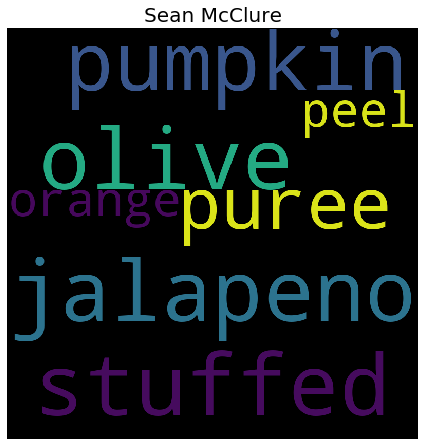

In [40]:
stopwords = set(STOPWORDS) 
stopwords.update(['mixoz', "n\'", 'fill', 'de', 'tbsp'])
for bartender in tmp.Bartender.unique():
    print(bartender)
    a = ' '.join(tmp[tmp.Bartender == bartender]['Ingredients'].item())
    a = ' '.join([i for i in a.split(' ') if i not in {'tbsp', 'h', 'bsp'}])
    if bartender == 'Russell Davis':
        print(a)
    wordcloud = WordCloud(width=800, height=800, 
                   background_color ='black', 
                   stopwords=stopwords, 
                   min_font_size=10,
                   random_state=1,
                         ).generate(''.join(a)) 

    plt.figure(figsize = (6, 6), facecolor=None) 
    plt.title(bartender, fontsize=20)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.savefig('Predict Bartender By Ingr {}.png'.format(bartender))
    plt.show()

In [ ]:
# What ingredients are good for mixing

In [109]:
i = df.set_index('Cocktail Name').Ingredients.str.split(',', expand=True).stack().reset_index('Cocktail Name').reset_index(drop=True)
i.columns = ['Cocktail Name', 'Ingredients']
i['Ingredients'] = i['Ingredients'].str.replace('.?[0-9]\.?[0-9]?( oz )?', '')
i['Ingredients'] = i['Ingredients'].str.replace('dash|ml|tsp', '')
i['Ingredients'] = i['Ingredients'].map(str.strip)
i['Ingredients'] = i['Ingredients'].str.lower()

i = i.set_index('Ingredients')
i['Ingredients Count'] = i.groupby('Ingredients').nunique()['Cocktail Name']
i = i.reset_index()

In [110]:
from collections import defaultdict
import math

min_val = 5
# stopwords = set(STOPWORDS) 
# stopwords.update(['c.', 'st.', 'des'])
# ingredients_cocktails_gr = i.groupby('Ingredients')['Cocktail Name'].unique().to_dict()
# ingredients_cocktails = defaultdict(set)
# for k, v in ingredients_cocktails_gr.items():
#     for ingr_w in k.split():
#         ingr_w = ingr_w.replace('(', '').replace(')', '')
#         if ingr_w in stopwords:
#             continue
#         for coctail in v:
#             ingredients_cocktails[ingr_w].add(coctail)
  
ingredients_cocktails_gr = i.groupby('Ingredients')['Cocktail Name'].unique().to_dict()
ingredients_cocktails = {k : set(v) for k, v in ingredients_cocktails_gr.items()}

ingredients = list(ingredients_cocktails.keys())
count = df['Cocktail Name'].nunique()
d = defaultdict(list)
for index1, ingr1 in enumerate(ingredients):
    if len(ingr1) <= 1:
        continue
    count_ingr1 = len(ingredients_cocktails[ingr1])
    if count_ingr1 < min_val:
        continue
    for ingr2 in ingredients[index1 + 1:]:
        if len(ingr2) <= 1:
            continue
        count_ingr2 = len(ingredients_cocktails[ingr2])
        if count_ingr2 < min_val:
            continue
            
        count_ingr12 = len(ingredients_cocktails[ingr1] & ingredients_cocktails[ingr2])
        try:
            pmi = math.log(count_ingr12) + math.log(count) - math.log(count_ingr1) - math.log(count_ingr2)
            #max_pmi = max(max_pmi, pmi)
            d[ingr1].append((ingr2, pmi))
            d[ingr2].append((ingr1, pmi))
        except ValueError:
            continue

In [140]:
# sort best fit.
from collections import OrderedDict
d1 = []
for ingr in ingredients:
    if not d[ingr]:
        continue
    top_ingr = sorted(d[ingr], reverse=True, key=lambda x: x[1])[:5]
    d1.append((ingr, top_ingr, top_ingr[0][1]))

res = sorted(d1, key=lambda x: x[2], reverse=True)
d1 = OrderedDict()
mapper = {ingredients[i]: i for i in range(len(ingredients))}

for i in range(0, len(res), 2):
    ingr1, ingrds, _ = res[i]
    
    #vec = [0] * len(ingredients)
    #for ingr in ingrds:
        #vec[mapper[ingr[0]]] = 1
         
    d1[ingr1] = [','.join([ingr[0] for ingr in ingrds])]

In [143]:
d1

OrderedDict([('tbsp sugar', ['ypiòca,orange juice']),
             ('oloroso sherry',
              ["regans' orange bitters,ginger beer,pineapple juice,luxardo triplum (triple sec),angostura bitters"]),
             ('english harbour rum',
              ['whole egg,nikka whisky taketsuru pure malt yo,pineapple juice,luxardo sangue morlacco cherry liqueur,egg white']),
             ('whole egg',
              ['english harbour rum,heavy cream,chocolate bitters,grenadine,honey']),
             ('orgeat',
              ['lemon,bourbon,c. drouin calvados selection,lime,egg white']),
             ('celery bitters',
              ["tonic water,lime,old tom gin,karlsson's gold vodka,junipero gin"]),
             ('lemon bitters',
              ['ypioca brasilizar cachaca prata reserva especial,rye whiskey,grenadine,absinthe,green chartreuse']),
             ('tonic water',
              ['celery bitters,luxardo limoncello,honey syrup,old tom gin,luxardo aperitivo']),
             ('bittermen

In [80]:
# sort worst fit.

d1 = []
for ingr in np.unique(list(d.keys())):
    top_ingr = sorted(d[ingr], reverse=False, key=lambda x: x[1])[:5]
    d1.append((ingr, top_ingr, top_ingr[0][1]))

sorted(d1, key=lambda x: x[2], reverse=False)

[('lemon juice',
  [('lime juice', -8.939318740417509),
   ("karlsson's gold vodka", -8.031060180240617),
   ('dry vermouth', -7.702556113268582),
   ('barsol primero quebranta pisco', -7.520234556474627),
   ('nikka whisky taketsuru pure malt yo', -7.451241684987675)],
  -8.939318740417509),
 ('lime juice',
  [('lemon juice', -8.939318740417509),
   ('luxardo triplum (triple sec)', -7.262628600974241),
   ('glenrothes vintage reserve', -6.960347729101308),
   ('h by hine', -6.899723107284872),
   ('luxardo fernet', -6.835184586147301)],
  -8.939318740417509),
 ("king's ginger liqueur",
  [('luxardo maraschino liqueur', -8.837536046107566),
   ('pink pigeon rum', -8.11969625295725),
   ('junipero gin', -8.041734711487539),
   ('luxardo sangue morlacco cherry liqueur', -7.86480400332846),
   ('luxardo amaro abano', -7.608870629191259)],
  -8.837536046107566),
 ('luxardo maraschino liqueur',
  [("king's ginger liqueur", -8.837536046107566),
   ('luxardo amaretto di saschira', -7.73892375

In [ ]:
# Glassware per locations

In [4]:
df.Glassware = df.Glassware.str.lower()
df_filtered = df.groupby('Glassware').filter(lambda x: len(x) > 1)

In [5]:
tmp = df_filtered.Glassware.value_counts().to_frame()
df_filtered = df_filtered.set_index('Glassware')
df_filtered['global_count'] = tmp['Glassware']

df_filtered = df_filtered.reset_index()
tmp = df_filtered.groupby('Location').Glassware.value_counts().to_frame()

df_filtered = df_filtered.set_index(['Location', 'Glassware'])
df_filtered['local_count'] = tmp['Glassware']
df_filtered = df_filtered.reset_index()

df_filtered = df_filtered.drop_duplicates()

df_filtered['glassware_by_locations'] = df_filtered.local_count / df_filtered.global_count

In [6]:
tmp = df_filtered.groupby('Location').apply(lambda x: x[x.glassware_by_locations == max(x.glassware_by_locations)].Glassware)
tmp = tmp.to_frame().reset_index()
tmp.drop('level_1', inplace=True, axis=1)

In [7]:
tmp[:10]

,Location,Glassware
0,Alameda,coupe
1,Atlanta,coupe
2,Austin,nick & nora
3,Austin,old fashioned glass
4,Boston,highball glass
5,Brooklyn,mug
6,Carlsbad,collins
7,Charleston,coupe
8,Chicago,double rocks glass
9,"Chicago, Ill",martini


In [8]:
region_loc = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')[['name', 'lat', 'lon']]
region_loc.name = region_loc.name.str.strip()
region_loc = region_loc.set_index('name')
region_loc = region_loc.T.to_dict()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


In [9]:
import os
os.environ["PROJ_LIB"] = "//anaconda3/share/proj"
from mpl_toolkits.basemap import Basemap

In [10]:
colors = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

colors = list(colors.keys())

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


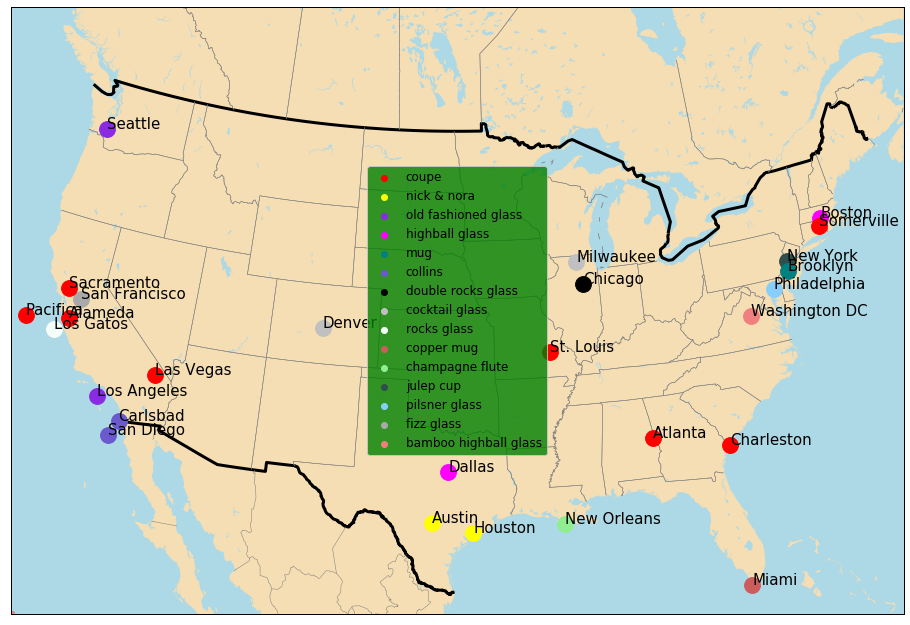

In [15]:
from mpl_toolkits.basemap import Basemap
import random

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
m = Basemap(width=5000000,height=3400000,projection='lcc',
            resolution="i", lat_0=40, lon_0=-97., ax=ax)

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='wheat',lake_color='lightblue')
m.drawcountries(color="k", linewidth=3)
m.drawstates(color="grey")

colors_glassware = {}
seen = set()
random.seed(0)
for k in tmp.Glassware.unique():
    i = random.randint(0, len(colors) - 1)
    while i in seen or i == 'green':
        i = random.randint(0, len(colors) - 1)
    seen.add(i)
    colors_glassware[k] = colors[i]
    
colors_glassware['highball glass'] = 'magenta'
colors_glassware['double rocks glass'] = 'black'
colors_glassware['coupe'] = 'red'
colors_glassware['nick & nora'] = 'yellow'
colors_glassware['champagne flute'] = 'lightgreen'

for (reg, coord) in region_loc.items():
    x, y = m(region_loc[reg]['lon'], region_loc[reg]['lat'])
    if reg == 'Washington':
        reg = 'Washington DC'
        
    tmp_sub = tmp[tmp["Location"] == reg]
    
    if tmp_sub.shape[0] == 0:
        continue
        
    glassware = tmp_sub.Glassware.iloc[0]
    if glassware == 'martini':
        continue
    if reg == 'Pacifica':
        m.ax.scatter([x-200000], [y-80000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-200000, y-80000, reg, fontsize=15)
    elif reg == 'Los Angeles':
        m.ax.scatter([x-70000], [y-50000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-70000, y-50000, reg, fontsize=15)
    elif reg == 'Alameda':
        m.ax.scatter([x-5000], [y-80000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-5000, y-80000, reg, fontsize=15)
    elif reg == 'Carlsbad':
        m.ax.scatter([x-5000], [y-70000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-5000, y-70000, reg, fontsize=15) 
    elif reg == 'San Francisco':
        m.ax.scatter([x+100000], [y-5000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x+100000, y-5000, reg, fontsize=15) 
    elif reg == 'Sacramento':
        m.ax.scatter([x-70000], [y-5000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-70000, y-5000, reg, fontsize=15)
    elif reg == 'New York':
        m.ax.scatter([x-70000], [y-50000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-70000, y-50000, reg, fontsize=15)
    elif reg == 'Boston':
        m.ax.scatter([x-70000], [y-50000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-70000, y-50000, reg, fontsize=15)
    else:
        m.ax.scatter([x-70000], [y-100000], s=250, facecolor=colors_glassware[glassware], zorder=2)
        plt.text(x-70000, y-100000, reg, fontsize=15)


for glassware in tmp.Glassware.unique():
    if glassware == 'martini':
        continue
    plt.scatter([0], [0], color=colors_glassware[glassware], label=glassware)

legend = plt.legend(frameon=1, loc='best', fontsize=12)
frame = legend.get_frame()

frame.set_facecolor('green')

#plt.tight_layout()
#plt.savefig('glassware loc.png')
plt.show()

In [103]:
# Garnish per locations

In [16]:
i = df.set_index('Location').Garnish.str.split(',', expand=True).stack().reset_index('Location').reset_index(drop=True)
i.columns = ['Location', 'Garnish']
i['Garnish'] = i['Garnish'].str.replace('[0-9] ', '') #remove numbers
i['Garnish'] = i['Garnish'].str.replace('rries$','rry') #unify plular and singular
i['Garnish']= i['Garnish'].map(str.strip) 
i['garnish_ingr'] = i['Garnish'].str.replace('[a-zA-Z]+$','') #split
i['garnish_ingr'] = i['garnish_ingr'][i['garnish_ingr'] != '']
i['garnish_type'] = i['Garnish'].str.extract('([a-zA-Z]+)$')
i['garnish_type'] = i['garnish_type'][i['garnish_type'] != 'Luxardo']
i['garnish_type'] = i['garnish_type'].str.lower()
i['garnish_ingr'] = i['garnish_ingr'].str.lower()

In [17]:
i = i.groupby('garnish_type').filter(lambda x: len(x) > 4)

In [18]:
tmp = i.garnish_type.value_counts().to_frame()
i = i.set_index('garnish_type')
i['global_count'] = tmp['garnish_type']

i = i.reset_index()
tmp = i.groupby('Location').garnish_type.value_counts().to_frame()

i = i.set_index(['Location', 'garnish_type'])
i['local_count'] = tmp['garnish_type']
i = i.reset_index()

i = i.drop_duplicates()

i['garnish_type_by_locations'] = i.local_count / i.global_count

In [19]:
tmp = i.groupby('Location').apply(lambda x: x[x.garnish_type_by_locations == max(x.garnish_type_by_locations)].garnish_type)
tmp = tmp.to_frame().reset_index()
tmp.drop('level_1', inplace=True, axis=1)

In [20]:
tmp.head()

,Location,garnish_type
0,Anaheim,wedge
1,Atlanta,twist
2,Austin,wedge
3,Boston,cinnamon
4,Brooklyn,twist


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


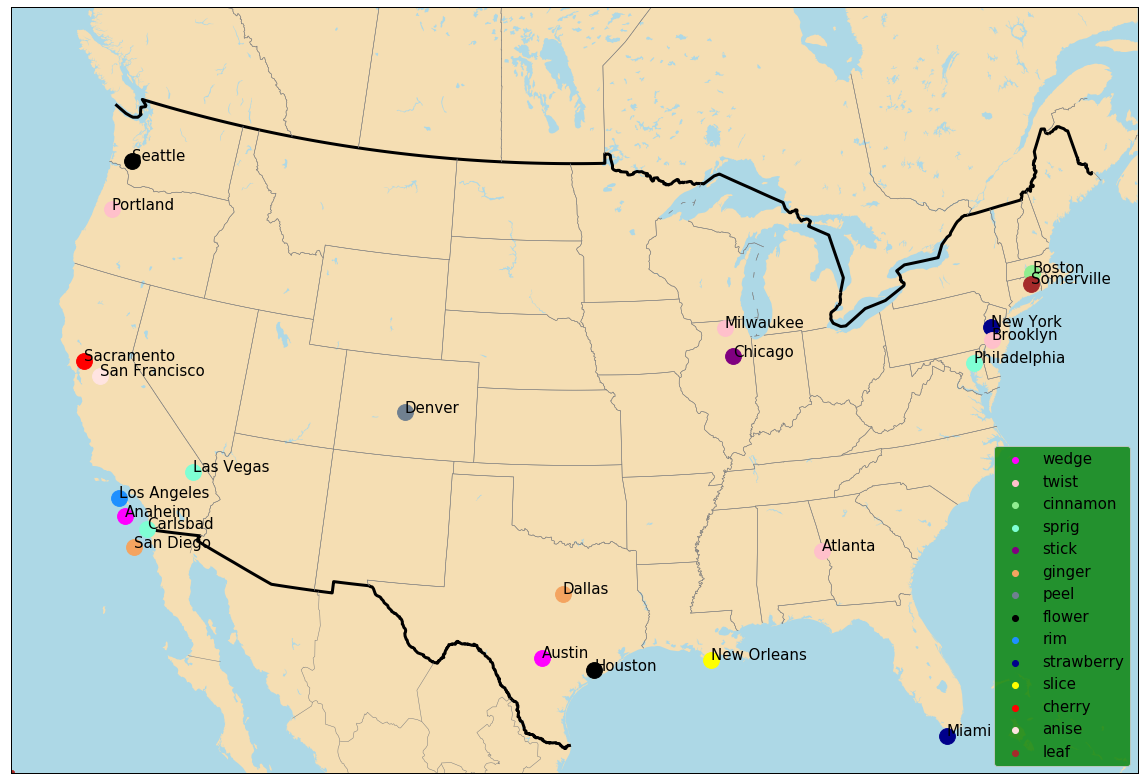

In [24]:
from mpl_toolkits.basemap import Basemap
import random

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
m = Basemap(width=5000000,height=3400000,projection='lcc',
            resolution="i", lat_0=40, lon_0=-97., ax=ax)

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='wheat',lake_color='lightblue')
m.drawcountries(color="k", linewidth=3)
m.drawstates(color="grey")

colors_garnish = {}
seen = set()
random.seed(10)
for k in tmp.garnish_type.unique():
    i = random.randint(0, len(colors) - 1)
    while i in seen or i == 'green':
        i = random.randint(0, len(colors) - 1)
    seen.add(i)
    colors_garnish[k] = colors[i]
    
colors_garnish['wedge'] = 'magenta'  
colors_garnish['flower'] = 'black'  
colors_garnish['slice'] = 'yellow'
colors_garnish['stick'] = 'purple'
colors_garnish['cinnamon'] = 'lightgreen'
colors_garnish['strawberry'] = 'darkblue'
colors_garnish['cherry'] = 'red'

for (reg, coord) in region_loc.items():
    x, y = m(region_loc[reg]['lon'], region_loc[reg]['lat'])
    tmp_sub = tmp[tmp["Location"] == reg]
    
    if tmp_sub.shape[0] == 0:
        continue
        
    garnish = tmp_sub.garnish_type.iloc[0]
    if garnish == 'wheel':
        continue
        
    if reg == 'Pacifica':
        m.ax.scatter([x-200000], [y-80000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-200000, y-80000, reg, fontsize=15)
    elif reg == 'Los Angeles':
        m.ax.scatter([x-70000], [y-50000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-70000, y-50000, reg, fontsize=15)
    elif reg == 'Alameda':
        m.ax.scatter([x-5000], [y-80000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-5000, y-80000, reg, fontsize=15)
    elif reg == 'Carlsbad':
        m.ax.scatter([x-5000], [y-70000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-5000, y-70000, reg, fontsize=15) 
    elif reg == 'San Francisco':
        m.ax.scatter([x+100000], [y-5000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x+100000, y-5000, reg, fontsize=15) 
    elif reg == 'Sacramento':
        m.ax.scatter([x-70000], [y-5000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-70000, y-5000, reg, fontsize=15)
    elif reg == 'New York':
        m.ax.scatter([x-70000], [y-50000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-70000, y-50000, reg, fontsize=15)
    elif reg == 'Boston':
        m.ax.scatter([x-70000], [y-50000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-70000, y-50000, reg, fontsize=15)
    else:
        m.ax.scatter([x-70000], [y-100000], s=250, facecolor=colors_garnish[garnish], zorder=2)
        plt.text(x-70000, y-100000, reg, fontsize=15)


for garnish in tmp.garnish_type.unique():
    if garnish == 'wheel':
        continue
    plt.scatter([0], [0], color=colors_garnish[garnish], label=garnish)

legend = plt.legend(frameon=1, loc=4, fontsize=15)
frame = legend.get_frame()

frame.set_facecolor('green')

plt.tight_layout()
#plt.savefig('garnish loc.png')
plt.show()